# Import

In [33]:
#For read CSV data
import pandas as pd

#For random a fecility in example
import random
from numpy import *

#For calculate projection of facility points
import shapely as shp

#For construct a network and calculate 'cost' function
import networkx as nx
import matplotlib.pyplot as plt

#For calculate position of dummy
import statistics

import numpy as np
from scipy import interpolate
from scipy.optimize import minimize

import random
import math
import time

#remove duplicated data from set
def unduplicate(data):
    undup_list = []
    for item in data:
        if item not in undup_list:
            undup_list.append(item)
    return undup_list

# Network projection function

In [34]:
def facility_projection(x0):

    edges_df = pd.read_csv("data_original_edges.csv")
    nodes_df = pd.read_csv("data_original_nodes.csv")

    edge_from = edges_df['origin_id'].tolist()
    edge_to = edges_df['destination'].tolist()
    edge_length = edges_df['total_cost'].tolist()
    edge_size = edges_df['width'].tolist()

    x_coordinates = nodes_df['x'].tolist()
    y_coordinates = nodes_df['y'].tolist()
    node_name = nodes_df['Node'].tolist()
    evacuee = nodes_df['Evacuees'].tolist()

    node_data = []
    for i in range(len(node_name)):
        node_data.append([str(node_name[i]),x_coordinates[i],y_coordinates[i],evacuee[i]])

    edge_data = []
    for i in range(len(edge_from)):
        edge_data.append([str(edge_from[i]),str(edge_to[i]),edge_length[i],edge_size[i]])

#Construct a set of edge in Shapely LineString
    line_set = []
    for i in range(len(edge_data)):
        for j in range(len(node_data)):
            if edge_data[i][0] == node_data[j][0]:
                p1 = node_data[j][1],node_data[j][2]
            else:
                pass
            if edge_data[i][1] == node_data[j][0]:
                p2 = node_data[j][1],node_data[j][2]
            else:
                pass
        line_set.append([shp.LineString([p1,p2]),(shp.Point(p1),shp.Point(p2))])
    line_set

    x0 = np.array(x0)
    facility = []
    for i in range(int(len(x0)/2)):
        facility.append([str(i) + '*',[x0[2*i],x0[(2*i)+1]]])

#Construct a set of facility point in Shapely Point
    point_set = []
    for i in range(len(facility)):
        point_set.append(shp.Point(facility[i][1]))
    point_set

#Project a set of facility points to nearest edge
    proj_point = []
    proj_line = []
    for i in range(len(point_set)):
        min = shp.shortest_line(point_set[i],line_set[0][0]).length
        count_point = []
        count_line = []
        for j in range(len(line_set)):
            sht_line = shp.shortest_line(point_set[i],line_set[j][0])
            dist = sht_line.length
            if min >= dist:
                min = dist
                count_point.append(shp.Point(sht_line.coords[-1]))
                count_line.append(j)
            else:
                pass
        proj_point.append(count_point[len(count_point)-1])
        proj_line.append(count_line[len(count_line)-1])

#Construct a set of projected facility points
    nvd_gen = []
    gen_set = []
    for i in range(len(proj_point)):
        nvd_gen.append(['node'+str(i), shp.get_coordinates(proj_point[i])[0]])
        gen_set.append('node'+str(i))

    node_remove = []
    node_temp = []
    for i in range(len(nvd_gen)):
        for j in range(len(node_data)):
            if nvd_gen[i][1][0] == node_data[j][1]:
                if nvd_gen[i][1][1] == node_data[j][2]:
                    node_remove.append([nvd_gen[i],node_data[j],node_data[j][3]])
                    node_temp.append(node_data[j][0])
                else:
                    pass
            else:
                pass

    edge_remove = []
    edge_add = []
    for i in range(len(node_remove)):
        for j in range(len(edge_data)):
            if node_remove[i][1][0] == edge_data[j][0]:
                if j in proj_line:
                    pass
                else:
                    edge_remove.append(edge_data[j])
                    edge_add.append([node_remove[i][0][0],edge_data[j][1],edge_data[j][2],edge_data[j][3]])
            elif node_remove[i][1][0] == edge_data[j][1]:
                if j in proj_line:
                    pass
                else:
                    edge_remove.append(edge_data[j])
                    edge_add.append([node_remove[i][0][0],edge_data[j][0],edge_data[j][2],edge_data[j][3]])
            else:
                pass

    to_add = []
    to_remove = []
    for i in range(len(proj_line)):
        to_remove.append(edge_data[proj_line[i]])
        e_len = edge_data[proj_line[i]][2]
        line_end = line_set[proj_line[i]][1]
        st_dist = e_len*(shp.distance(proj_point[i],line_end[0])/shp.distance(line_end[0],line_end[1]))
        to_add.append([nvd_gen[i][0],edge_data[proj_line[i]][0],st_dist,edge_data[proj_line[i]][3]])
        nd_dist = e_len*(shp.distance(proj_point[i],line_end[1])/shp.distance(line_end[0],line_end[1]))
        to_add.append([nvd_gen[i][0],edge_data[proj_line[i]][1],nd_dist,edge_data[proj_line[i]][3]])

    to_add_remove = []

    for i in range(len(node_remove)):
        for j in range(len(to_add)):
            if node_remove[i][1][0] == to_add[j][1]:
                to_add_remove.append(to_add[j])
                to_add.append([to_add[j][0],node_remove[i][0][0],to_add[j][2],to_add[j][3]])

    for j in range(len(to_add)):
        if to_add[j][2] == 0:
            to_add_remove.append(to_add[j])
        else:
            pass

    to_add_remove = unduplicate(to_add_remove)
    
    for i in range(len(to_add_remove)):
        to_add.remove(to_add_remove[i])

    temp = []
    temp_remove = []
    for i in range(len(edge_add)):
        for j in range(len(to_add_remove)):
            if edge_add[i][1] == to_add_remove[j][1]:
                temp.append([edge_add[i][0],to_add_remove[j][0],edge_add[i][2],edge_add[i][3]])
                temp_remove.append(edge_add[i])
            else:
                pass

    temp_temp = []
    for i in range(len(temp)):
        for j in range(len(temp)):
            if temp[i][0] == temp[j][1]:
                if temp[i][1] == temp [j][0]:
                    temp_temp.append(temp[i])   

    temp_remove = unduplicate(temp_remove)
    
    for i in range(int(len(temp_temp)/2)):
        edge_add.append(temp_temp[2*i])

    for i in range(len(temp_remove)):
        if temp_remove[i] in edge_add:
            edge_add.remove(temp_remove[i])

#Remove edge between neighbor of facility points
    to_remove = unduplicate(to_remove)
    for i in range(len(to_remove)):
        if to_remove[i] in edge_data:
            edge_data.remove(to_remove[i])

    edge_remove = unduplicate(edge_remove)
    for i in range(len(edge_remove)):
        if edge_remove[i] in edge_data:
            edge_data.remove(edge_remove[i])

    for i in range(len(node_remove)):
        if node_remove[i][1] in node_data:
            node_data.remove(node_remove[i][1])

#Construct a graph G
    G = nx.Graph()

    for i in range(len(node_data)):
        G.add_node(node_data[i][0], pos=(node_data[i][1],node_data[i][2]), evacuees=node_data[i][3])

    for k in range(len(edge_data)):
        G.add_edge(edge_data[k][0], edge_data[k][1], weight=int(round(edge_data[k][2]/2,0)), capacity=edge_data[k][3]*2)

    for k in range(len(edge_add)):
        G.add_edge(edge_add[k][0], edge_add[k][1], weight=int(round(edge_add[k][2]/2,0)), capacity=edge_add[k][3]*2)

    for k in range(len(to_add)):
        G.add_edge(to_add[k][0], to_add[k][1], weight=int(round(to_add[k][2]/2,0)), capacity=to_add[k][3]*2)

    for i in range(len(nvd_gen)):
        G.add_node(nvd_gen[i][0] ,pos=nvd_gen[i][1], evacuees=0)

    for i in range(len(nvd_gen)):
        for j in range(len(node_remove)):
            if nvd_gen[i]==node_remove[j][0]:
                G.add_node(nvd_gen[i][0] ,pos=nvd_gen[i][1], evacuees=node_remove[j][2])
            else:
                pass

#Output graph G and a set of facility nodes (name) on G
    return G,gen_set

# cost(x) function

In [35]:
def cost(x0):

    edges_df = pd.read_csv("data_original_edges.csv")
    nodes_df = pd.read_csv("data_original_nodes.csv")

    edge_from = edges_df['origin_id'].tolist()
    edge_to = edges_df['destination'].tolist()
    edge_length = edges_df['total_cost'].tolist()
    edge_size = edges_df['width'].tolist()

    x_coordinates = nodes_df['x'].tolist()
    y_coordinates = nodes_df['y'].tolist()
    node_name = nodes_df['Node'].tolist()
    evacuee = nodes_df['Evacuees'].tolist()

    node_data = []
    for i in range(len(node_name)):
        node_data.append([str(node_name[i]),x_coordinates[i],y_coordinates[i],evacuee[i]])

    edge_data = []
    for i in range(len(edge_from)):
        edge_data.append([str(edge_from[i]),str(edge_to[i]),edge_length[i]/edge_size[i],edge_size[i]])

#Construct a set of edge in Shapely LineString
    line_set = []
    for i in range(len(edge_data)):
        for j in range(len(node_data)):
            if edge_data[i][0] == node_data[j][0]:
                p1 = node_data[j][1],node_data[j][2]
            else:
                pass
            if edge_data[i][1] == node_data[j][0]:
                p2 = node_data[j][1],node_data[j][2]
            else:
                pass
        line_set.append([shp.LineString([p1,p2]),(shp.Point(p1),shp.Point(p2))])

    facility = []
    for i in range(int(len(x0)/2)):
        facility.append([str(i) + '*',[x0[2*i],x0[(2*i)+1]]])

#Construct a set of facility point in Shapely Point
    point_set = []
    for i in range(len(facility)):
        point_set.append(shp.Point(facility[i][1]))

#Project a set of facility points to nearest edge
    proj_point = []
    proj_line = []
    for i in range(len(point_set)):
        min = shp.shortest_line(point_set[i],line_set[0][0]).length
        count_point = []
        count_line = []
        for j in range(len(line_set)):
            sht_line = shp.shortest_line(point_set[i],line_set[j][0])
            dist = sht_line.length
            if min >= dist:
                min = dist
                count_point.append(shp.Point(sht_line.coords[-1]))
                count_line.append(j)
            else:
                pass
        proj_point.append(count_point[len(count_point)-1])
        proj_line.append(count_line[len(count_line)-1])

#Construct a set of projected facility points
    nvd_gen = []
    facility_nodes = []
    for i in range(len(proj_point)):
        nvd_gen.append(['node'+str(i), shp.get_coordinates(proj_point[i])])
        facility_nodes.append('node'+str(i))

#Add edge for facility points and neighbor points
    edge_add = []
    to_remove = []
    for i in range(len(proj_line)):
        to_remove.append(edge_data[proj_line[i]])
        e_len = edge_data[proj_line[i]][2]
        line_end = line_set[proj_line[i]][1]
        st_dist = e_len*(shp.distance(proj_point[i],line_end[0])/shp.distance(line_end[0],line_end[1]))
        edge_add.append([edge_data[proj_line[i]][0],nvd_gen[i][0],st_dist])
        nd_dist = e_len*(shp.distance(proj_point[i],line_end[1])/shp.distance(line_end[0],line_end[1]))
        edge_add.append([nvd_gen[i][0],edge_data[proj_line[i]][1],nd_dist])

#Remove edge between neighbor of facility points
    to_remove = unduplicate(to_remove)
    for i in range(len(to_remove)):
        edge_data.remove(to_remove[i])

#Construct a graph G
    G = nx.Graph()

    for i in range(len(node_data)):
        G.add_node(node_data[i][0], pos=(node_data[i][1],node_data[i][2]))

    for i in range(len(edge_data)):
        G.add_edge(edge_data[i][0], edge_data[i][1], weight=edge_data[i][2])

    for i in range(len(edge_add)):
        G.add_edge(edge_add[i][0], edge_add[i][1], weight=edge_add[i][2])

    for i in range(len(nvd_gen)):
        G.add_node(nvd_gen[i][0] ,pos=nvd_gen[i][1][0])

#Construct graph H
    H = nx.Graph()
    pos = nx.get_node_attributes(G, 'pos')
    coor = []
    for value in pos.values():
        temp = value
        coor.append(temp)
    x_coor = []
    y_coor = []
    for i in range(len(coor)):
        x_coor.append(coor[i][0])
        y_coor.append(coor[i][1])

    for i in range(len(list(G))):
        H.add_node(list(G)[i], pos=(x_coor[i],y_coor[i]))
    for e in G.edges():
        wt = nx.get_edge_attributes(G, "weight")[e]
        H.add_edge(list(e)[0],list(e)[1], weight=wt)

#Add 'dummy' node and edges to H
    H.add_node('dummy', pos=(0,0))
    for i in range(len(facility_nodes)):
        H.add_edge('dummy', facility_nodes[i], weight=0)
    
#Calculate sum value
    estp = []
    for i in range(len(list(G))):
        stp = nx.shortest_path_length(H, source=list(G)[i], target='dummy', weight='weight')
        estp.append(stp**2)
    fn_sum = sum(estp)
    
    return fn_sum

# Sample generator function

In [36]:
def sample_gen(n,m):

    edges_df = pd.read_csv("data_original_edges.csv")
    nodes_df = pd.read_csv("data_original_nodes.csv")

    edge_from = edges_df['origin_id'].tolist()
    edge_to = edges_df['destination'].tolist()
    edge_length = edges_df['total_cost'].tolist()
    edge_size = edges_df['width'].tolist()

    x_coordinates = nodes_df['x'].tolist()
    y_coordinates = nodes_df['y'].tolist()
    node_name = nodes_df['Node'].tolist()
    evacuee = nodes_df['Evacuees'].tolist()

    node_data = []
    for i in range(len(node_name)):
        node_data.append([str(node_name[i]),x_coordinates[i],y_coordinates[i],evacuee[i]])

    edge_data = []
    for i in range(len(edge_from)):
        edge_data.append([str(edge_from[i]),str(edge_to[i]),edge_length[i]/edge_size[i],edge_size[i]])

    Test = nx.Graph()

    for i in range(len(node_data)):
        Test.add_node(node_data[i][0], pos=(node_data[i][1],node_data[i][2]))

    for j in range(len(edge_data)):
        Test.add_edge(edge_data[j][0], edge_data[j][1])

    cycles = nx.minimum_cycle_basis(Test)

    cycles_pos = []
    for i in range(len(cycles)):
        cycles_collect = []
        for j in range(len(cycles[i])):
            for k in range(len(node_data)):
                if cycles[i][j]==node_data[k][0]:
                    cycles_collect.append([node_data[k][1],node_data[k][2]])
                else:
                    pass
        cycles_pos.append(cycles_collect)

    cycles_avg = []
    for i in range(len(cycles_pos)):
        average = [sum(x)/len(x) for x in zip(*cycles_pos[i])]
        cycles_avg.append(average)

    if m > len(cycles_avg):
        random.seed(n)
        random_sample = random.sample(range(0,int(len(cycles_avg))),int(len(cycles_avg))-1)

        x0 = []
        for i in random_sample:
            x0.append(cycles_avg[i][0])
            x0.append(cycles_avg[i][1])

        for i in range(m-len(cycles_avg)+1):
            x0.append(random.uniform(max(x_coordinates),min(x_coordinates)))
            x0.append(random.uniform(max(y_coordinates),min(y_coordinates)))

    else:
        random.seed(n)
        random_sample = random.sample(range(0,int(len(cycles_avg))),m)

        x0 = []
        for i in random_sample:
            x0.append(cycles_avg[i][0])
            x0.append(cycles_avg[i][1])
    return x0

# Gradient descent (momentum) function

In [37]:
def gradient_momentum(x0):

    def grad_descent(x0):

        x0_add = []
        for i in range(len(x0)):
            eps_add = []
            for j in range(len(x0)):
                if i == j:
                    eps_add.append(x0[i]+eps)
                else:
                    eps_add.append(x0[j])
            x0_add.append(eps_add)

        grad_set = []
        for i in range(len(x0_add)):
            grad = (cost(x0_add[i])-cost(x0))/eps
            grad_set.append(grad)

        x1 = []
        for i in range(len(x0)):
            x1.append(x0[i]-(lrate*grad_set[i])+(alpha*Delta[i]))

        return x1
    
    xn_collect = []
    iter_data = []

    eps = (1e-1)
    lrate = (1e-10)
    alpha = 9/10

    Delta = []
    for i in range(len(x0)):
        Delta.append(0)
        
    counter = 0

    while counter < 300:
        xn_collect.append(x0)
        iter_data.append(cost(x0))
        x1 = grad_descent(x0)
        Delta = []
        for i in range(len(x0)):
            Delta.append(x1[i]-x0[i])
        x0 = []
        for i in range(len(x1)):
            x0.append(x1[i])
        counter += 1

    xn_collect.append(x0)
    iter_data.append(cost(x0))
    
    k = iter_data.index(min(iter_data))
    
    return xn_collect[k],iter_data

In [38]:
def gradient_momentum(x0):

    def grad_descent(x0):

        x0_add = []
        for i in range(len(x0)):
            eps_add = []
            for j in range(len(x0)):
                if i == j:
                    eps_add.append(x0[i]+eps)
                else:
                    eps_add.append(x0[j])
            x0_add.append(eps_add)

        grad_set = []
        for i in range(len(x0_add)):
            grad = (cost(x0_add[i])-cost(x0))/eps
            grad_set.append(grad)

        return grad_set
    
    xn_collect = []
    iter_data = []

    xn_collect.append(x0)
    iter_data.append(cost(x0))

    eps = (1e-1)
    lrate = (1e-10)
    alpha = 9/10

    grad_set = grad_descent(x0)
    x1 = []
    for i in range(len(x0)):
        x1.append(x0[i]-(lrate*grad_set[i]))
        
    xn_collect.append(x1)
    iter_data.append(cost(x1))
        
    counter = counter = len(xn_collect)

    while counter < 300:
        delta_set = []
        for i in range(len(x1)):
            delta_set.append(x1[i]-x0[i])
        x0 = []
        for i in range(len(x1)):
            x0.append(x1[i])
        grad_set = grad_descent(x0)
        x1 = []
        for i in range(len(x0)):
            x1.append(x0[i]-(lrate*grad_set[i])+(alpha*delta_set[i]))
        xn_collect.append(x1)
        iter_data.append(cost(x1))
        counter += 1
    
    k = iter_data.index(min(iter_data))
    
    return xn_collect[k],iter_data

# Time-expanded and flow(t) functions

In [39]:
def time_expanded(time, G, sink_nodes):
  from numpy import inf
  source_nodes = [g for g in G if g not in sink_nodes]
  te_G = nx.DiGraph()
  for t in range(time+1):
    for i in range(len(list(G))):
      te_G.add_node((str(list(G)[i]) + '(' + str(t) + ')'), pos = (t, len(list(G))-i))

    for k in range(len(list(te_G))-(len(source_nodes) + len(sink_nodes))):
      te_G.add_edge(str(list(te_G)[k]), str(list(te_G)[k + len(source_nodes) + len(sink_nodes)]), capacity = math.inf)
  te_G.add_node('x*', pos = (-1, len(source_nodes)))
  for i in range(len(sink_nodes)):
    te_G.add_node(str(sink_nodes[i]) + '*', pos = ((time+1)*(i+1)/(len(sink_nodes)+1), -len(sink_nodes)))
  for l in range(len(list(G))):
    te_G.add_edge('x*', str(list(te_G)[l]), capacity = nx.get_node_attributes(G, "evacuees")[list(G)[l]])
  te_G.add_node('zeta', pos = ((time+1)/2, -len(sink_nodes)-1))

  for t in range(time+1):
    for e in G.edges():
      weight = nx.get_edge_attributes(G, "weight")[e]
      if t+weight <= time:
        te_G.add_edge(str(list(e)[0]) + '(' + str(t) + ')', str(list(e)[1]) + '(' + str(t + (nx.get_edge_attributes(G, "weight"))[e]) + ')', capacity = nx.get_edge_attributes(G, "capacity")[e])
        te_G.add_edge(str(list(e)[1]) + '(' + str(t) + ')', str(list(e)[0]) + '(' + str(t + (nx.get_edge_attributes(G, "weight"))[e]) + ')', capacity = nx.get_edge_attributes(G, "capacity")[e])
    for i in range(len(sink_nodes)):
      te_G.add_edge(str(sink_nodes[i]) + '(' + str(t) + ')', str(sink_nodes[i]) + '*', capacity = math.inf)
  for i in range(len(sink_nodes)):
    te_G.add_edge(str(sink_nodes[i]) + '*', 'zeta', capacity = math.inf)
  return(te_G)

def flow_te(time, G, sink_nodes):
  flow_value = nx.maximum_flow_value(time_expanded(time, G, sink_nodes), "x*", "zeta")
  return(flow_value)

# Result Problem 1

In [40]:
import random
random.seed(2025)
random_test = (random.sample(range(0,200),1))
random_test

[142]

In [41]:
edges_df = pd.read_csv("data_original_edges.csv")
nodes_df = pd.read_csv("data_original_nodes.csv")

edge_from = edges_df['origin_id'].tolist()
edge_to = edges_df['destination'].tolist()
edge_length = edges_df['total_cost'].tolist()
edge_size = edges_df['width'].tolist()

x_coordinates = nodes_df['x'].tolist()
y_coordinates = nodes_df['y'].tolist()
node_name = nodes_df['Node'].tolist()
evacuee = nodes_df['Evacuees'].tolist()

data_result = []
iter_df = []
xn_df = []

Number of facilities: 1
Function cost(x0) values is 17905885.778749727
Time used in Gradient decent (momentum) calculation: 760.6769044399261
Function flow(100) values is 320
Time used in flow(t) calculation: 844.8413500785828


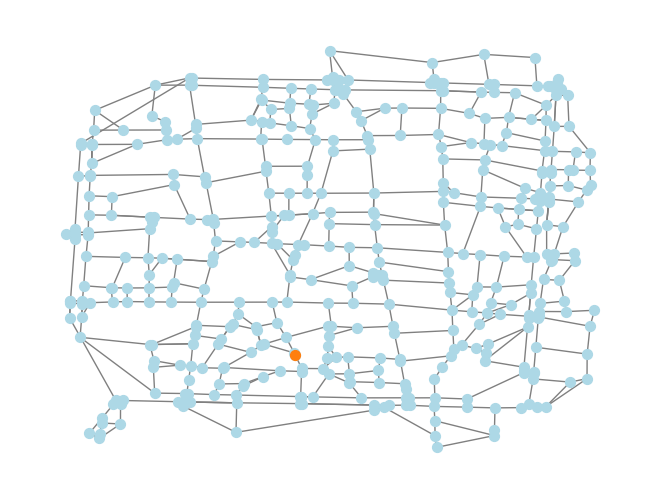

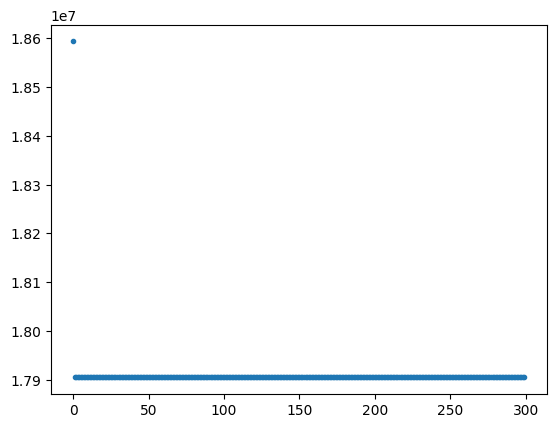

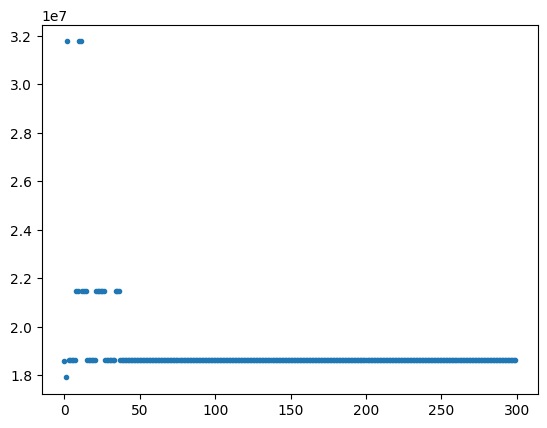

Number of facilities: 2
Function cost(x0) values is 7487731.642385384
Time used in Gradient decent (momentum) calculation: 1110.3731379508972
Function flow(100) values is 489
Time used in flow(t) calculation: 836.399498462677


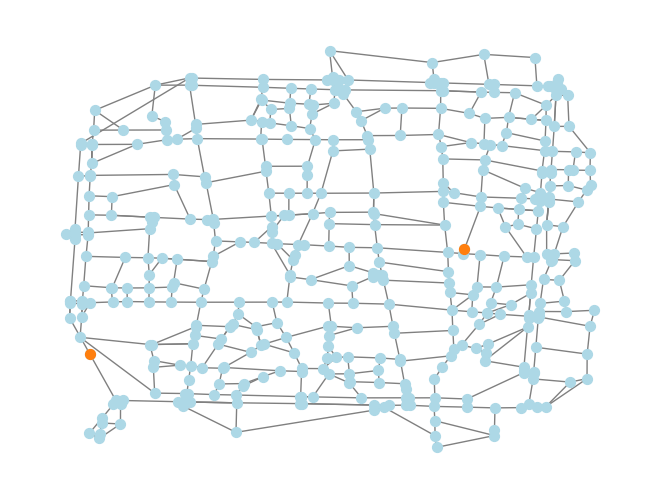

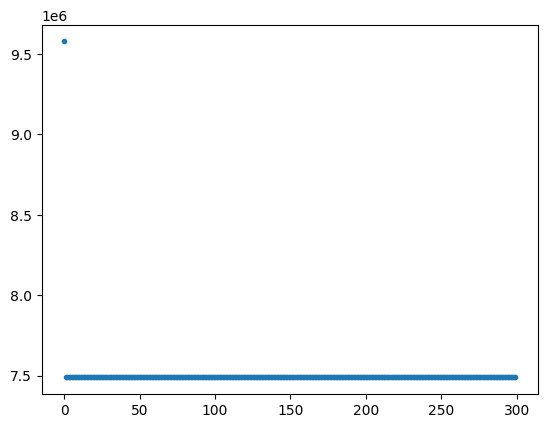

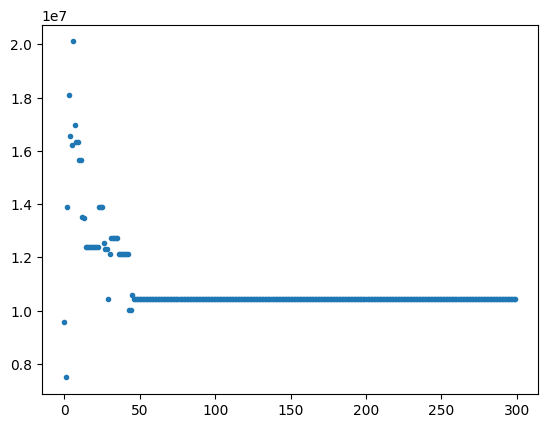

Number of facilities: 3
Function cost(x0) values is 4444335.182088217
Time used in Gradient decent (momentum) calculation: 1546.769508600235
Function flow(100) values is 1053
Time used in flow(t) calculation: 921.9858794212341


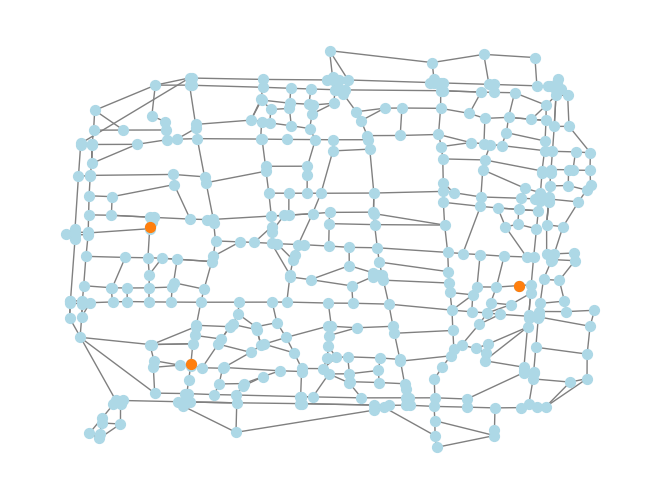

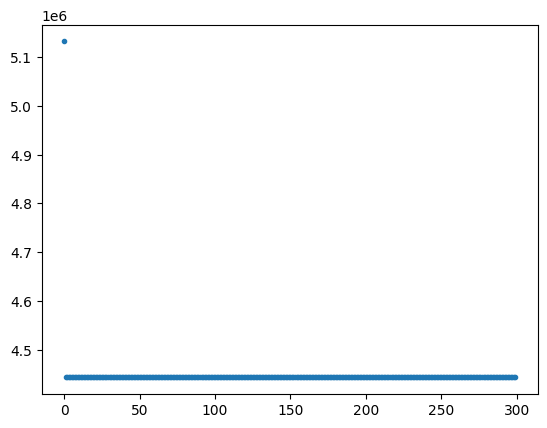

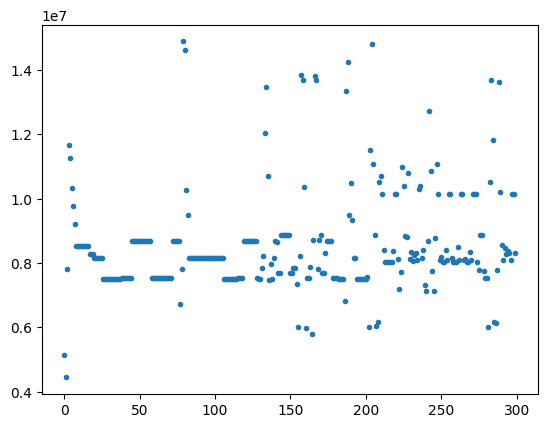

In [42]:
m = 1
while m <= 3:
    print('Number of facilities: '+ str(m))
    start_xn = time.time()
    xn_set = []
    cost_xn = []
    iter_collect = []
    for n in random_test:
        x0 = sample_gen(n,m)
        xn,iter_data = gradient_momentum(x0)
        xn_set.append(xn)
        cost_xn.append(cost(xn))
        iter_collect.append(iter_data)
    stop_xn = time.time()    
    k = cost_xn.index(min(cost_xn))
    print('Function cost(x0) values is '+ str(cost_xn[k]))
    print('Time used in Gradient decent (momentum) calculation: '+ str(stop_xn-start_xn))

    G,facility_list = facility_projection(xn_set[k])
    start_flow = time.time()
    t = 100
    flow = flow_te(t, G, facility_list)
    print('Function flow(100) values is '+ str(flow))
    stop_flow = time.time()
    print('Time used in flow(t) calculation: '+ str(stop_flow-start_flow))

    G_pos = nx.get_node_attributes(G, 'pos')
    edge_labels = nx.get_edge_attributes(G, "weight")
    
    nx.draw(G, G_pos, node_color='lightblue', edge_color='gray', node_size=50, font_size=8)
    nx.draw_networkx_nodes(G, G_pos, nodelist = facility_list, node_size = 50, node_color="tab:orange")
    plt.savefig('figure/network-bd-gd-momentum-'+ str(m) +'.pdf')
    plt.show()

    iter_count = len(iter_collect[k])
    iter_t = np.arange(iter_count)
    iter_set = []
    iter_dum = math.inf
    for i in range(iter_count):
        if iter_collect[k][i] < iter_dum:
            iter_set.append(iter_collect[k][i])
            iter_dum = iter_collect[k][i]
        else:
            iter_set.append(iter_dum)
    
    iter_plot = np.array(iter_set)
    plt.plot(iter_t,iter_plot, '.')
    plt.savefig('figure/iteration-bd-gd-momentum-'+ str(m) +'.pdf')
    plt.show()

    iter_plot = []
    for i in range(len(iter_collect[k])):
        iter_plot.append(iter_collect[k][i])
    iter_t = np.arange(len(iter_plot))
    iter_plot = np.array(iter_plot)
    plt.plot(iter_t,iter_plot, '.')
    plt.show()

    data_result.append([m,flow,stop_flow-start_flow,cost_xn[k],stop_xn-start_xn])
    iter_df.append(iter_set)
    xn_df.append(xn_set[k])
    m+=1

Number of facilities: 4
Function cost(x0) values is 3682793.320325837
Time used in Gradient decent (momentum) calculation: 2011.9464027881622
Function flow(100) values is 1429
Time used in flow(t) calculation: 844.3786149024963


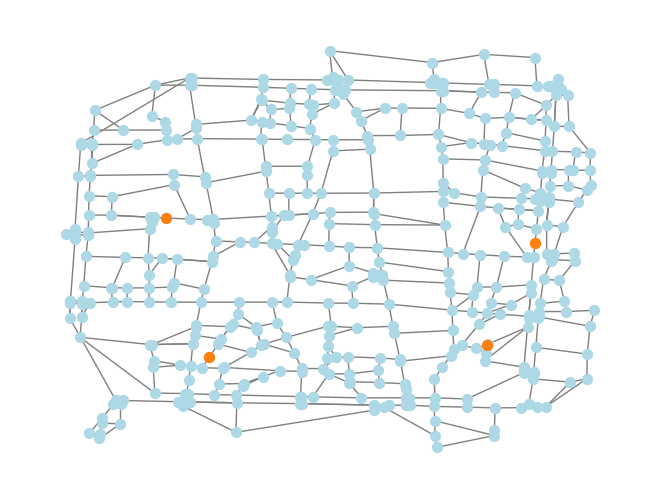

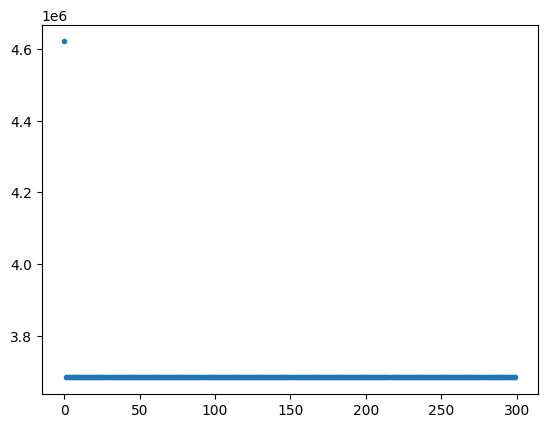

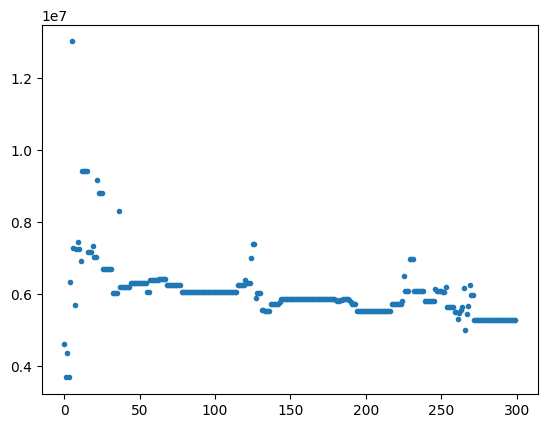

Number of facilities: 5
Function cost(x0) values is 3289307.330060475
Time used in Gradient decent (momentum) calculation: 2384.6049025058746
Function flow(100) values is 2057
Time used in flow(t) calculation: 853.7653288841248


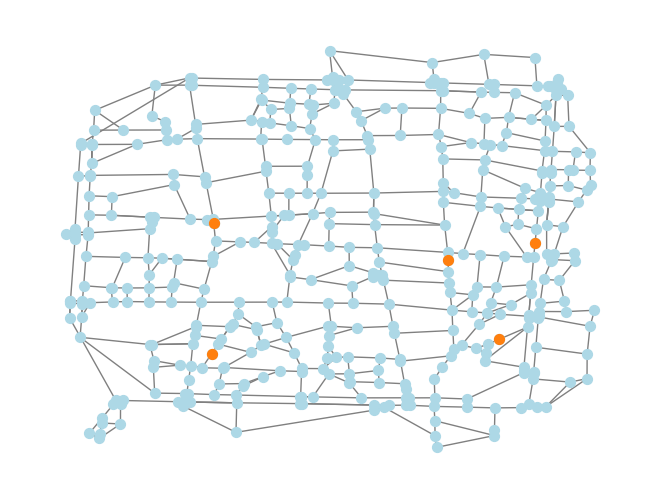

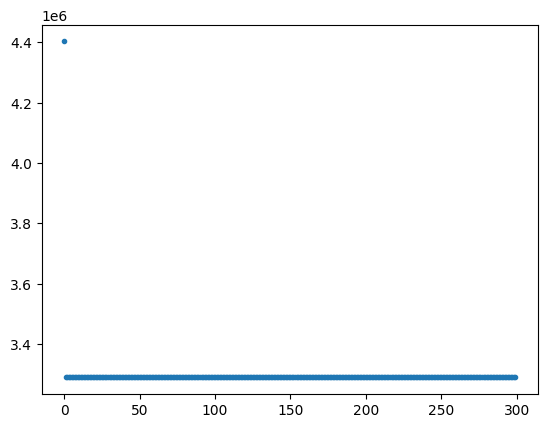

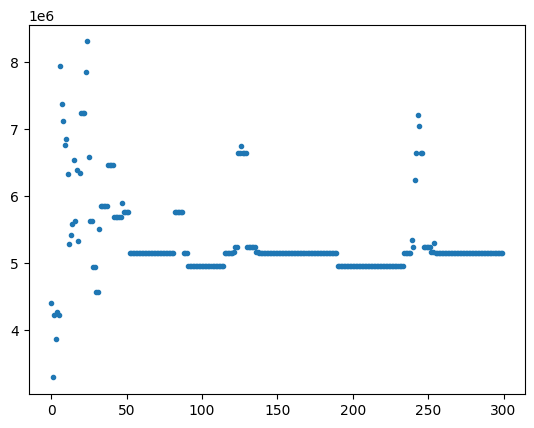

Number of facilities: 6
Function cost(x0) values is 2910849.9216238563
Time used in Gradient decent (momentum) calculation: 2731.4239587783813
Function flow(100) values is 2131
Time used in flow(t) calculation: 816.8732814788818


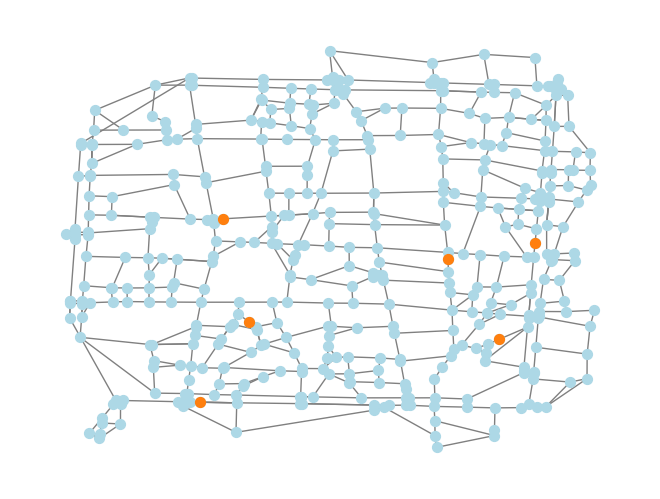

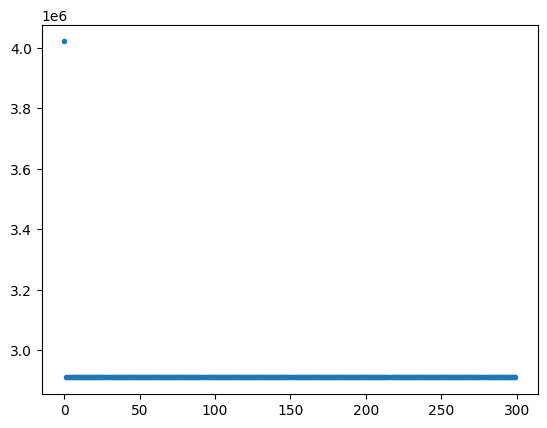

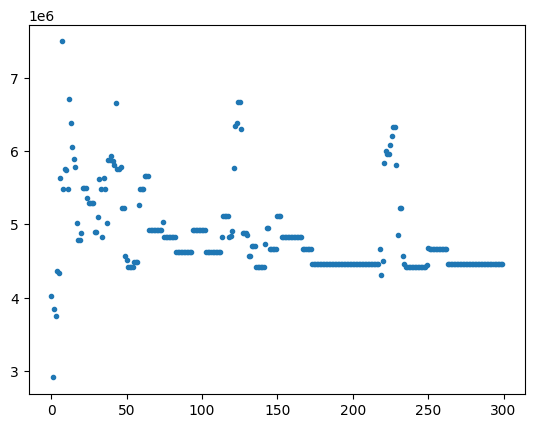

In [43]:
while m <= 6:
    print('Number of facilities: '+ str(m))
    start_xn = time.time()
    xn_set = []
    cost_xn = []
    iter_collect = []
    for n in random_test:
        x0 = sample_gen(n,m)
        xn,iter_data = gradient_momentum(x0)
        xn_set.append(xn)
        cost_xn.append(cost(xn))
        iter_collect.append(iter_data)
    stop_xn = time.time()    
    k = cost_xn.index(min(cost_xn))
    print('Function cost(x0) values is '+ str(cost_xn[k]))
    print('Time used in Gradient decent (momentum) calculation: '+ str(stop_xn-start_xn))

    G,facility_list = facility_projection(xn_set[k])
    start_flow = time.time()
    t = 100
    flow = flow_te(t, G, facility_list)
    print('Function flow(100) values is '+ str(flow))
    stop_flow = time.time()
    print('Time used in flow(t) calculation: '+ str(stop_flow-start_flow))

    G_pos = nx.get_node_attributes(G, 'pos')
    edge_labels = nx.get_edge_attributes(G, "weight")
    
    nx.draw(G, G_pos, node_color='lightblue', edge_color='gray', node_size=50, font_size=8)
    nx.draw_networkx_nodes(G, G_pos, nodelist = facility_list, node_size = 50, node_color="tab:orange")
    plt.savefig('figure/network-bd-gd-momentum-'+ str(m) +'.pdf')
    plt.show()

    iter_count = len(iter_collect[k])
    iter_t = np.arange(iter_count)
    iter_set = []
    iter_dum = math.inf
    for i in range(iter_count):
        if iter_collect[k][i] < iter_dum:
            iter_set.append(iter_collect[k][i])
            iter_dum = iter_collect[k][i]
        else:
            iter_set.append(iter_dum)
    
    iter_plot = np.array(iter_set)
    plt.plot(iter_t,iter_plot, '.')
    plt.savefig('figure/iteration-bd-gd-momentum-'+ str(m) +'.pdf')
    plt.show()

    iter_plot = []
    for i in range(len(iter_collect[k])):
        iter_plot.append(iter_collect[k][i])
    iter_t = np.arange(len(iter_plot))
    iter_plot = np.array(iter_plot)
    plt.plot(iter_t,iter_plot, '.')
    plt.show()

    data_result.append([m,flow,stop_flow-start_flow,cost_xn[k],stop_xn-start_xn])
    iter_df.append(iter_set)
    xn_df.append(xn_set[k])
    m+=1

Number of facilities: 7
Function cost(x0) values is 2707708.2882961202
Time used in Gradient decent (momentum) calculation: 3139.372841835022
Function flow(100) values is 2420
Time used in flow(t) calculation: 829.9037787914276


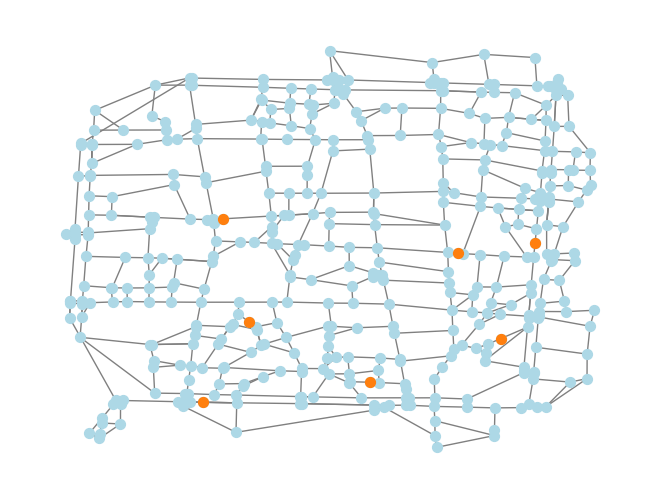

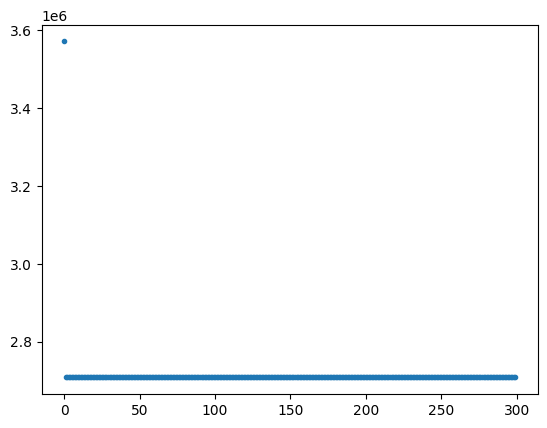

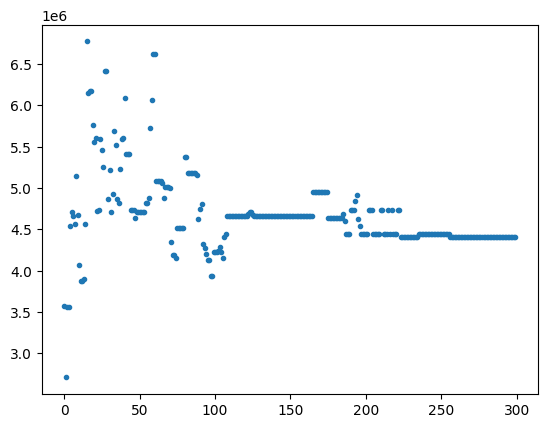

Number of facilities: 8
Function cost(x0) values is 2010674.781361291
Time used in Gradient decent (momentum) calculation: 3621.049656391144
Function flow(100) values is 3067
Time used in flow(t) calculation: 834.022114276886


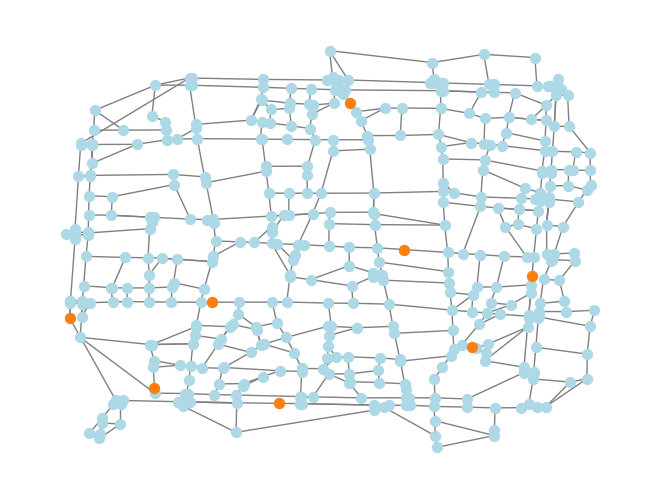

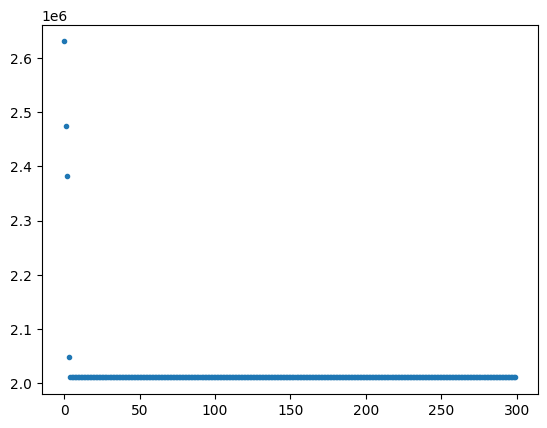

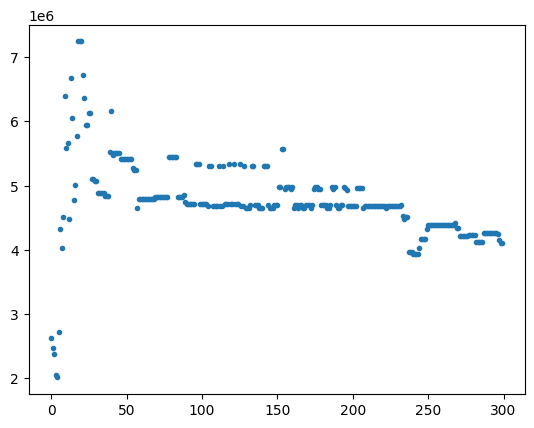

Number of facilities: 9
Function cost(x0) values is 1998998.4435616885
Time used in Gradient decent (momentum) calculation: 4087.651031970978
Function flow(100) values is 3449
Time used in flow(t) calculation: 841.8137843608856


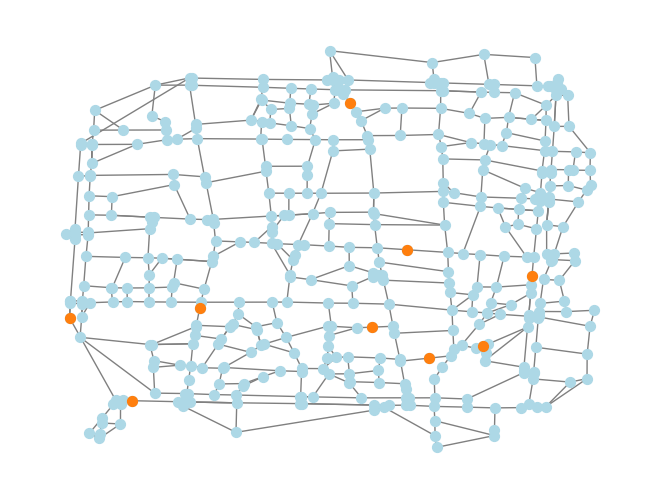

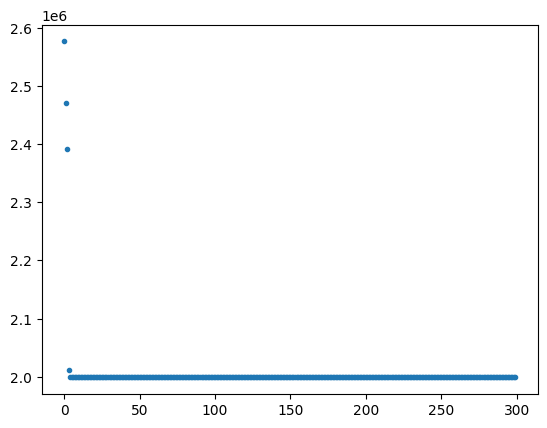

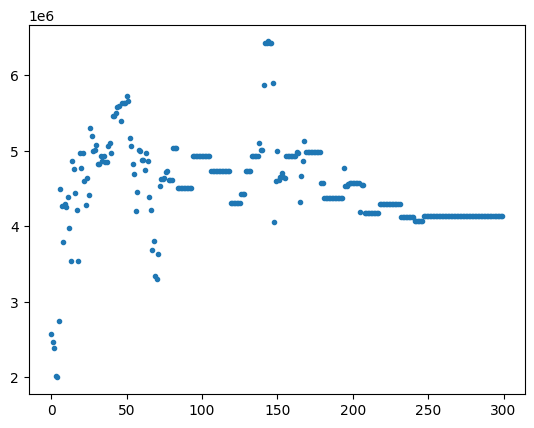

In [44]:
while m <= 9:
    print('Number of facilities: '+ str(m))
    start_xn = time.time()
    xn_set = []
    cost_xn = []
    iter_collect = []
    for n in random_test:
        x0 = sample_gen(n,m)
        xn,iter_data = gradient_momentum(x0)
        xn_set.append(xn)
        cost_xn.append(cost(xn))
        iter_collect.append(iter_data)
    stop_xn = time.time()    
    k = cost_xn.index(min(cost_xn))
    print('Function cost(x0) values is '+ str(cost_xn[k]))
    print('Time used in Gradient decent (momentum) calculation: '+ str(stop_xn-start_xn))

    G,facility_list = facility_projection(xn_set[k])
    start_flow = time.time()
    t = 100
    flow = flow_te(t, G, facility_list)
    print('Function flow(100) values is '+ str(flow))
    stop_flow = time.time()
    print('Time used in flow(t) calculation: '+ str(stop_flow-start_flow))

    G_pos = nx.get_node_attributes(G, 'pos')
    edge_labels = nx.get_edge_attributes(G, "weight")
    
    nx.draw(G, G_pos, node_color='lightblue', edge_color='gray', node_size=50, font_size=8)
    nx.draw_networkx_nodes(G, G_pos, nodelist = facility_list, node_size = 50, node_color="tab:orange")
    plt.savefig('figure/network-bd-gd-momentum-'+ str(m) +'.pdf')
    plt.show()

    iter_count = len(iter_collect[k])
    iter_t = np.arange(iter_count)
    iter_set = []
    iter_dum = math.inf
    for i in range(iter_count):
        if iter_collect[k][i] < iter_dum:
            iter_set.append(iter_collect[k][i])
            iter_dum = iter_collect[k][i]
        else:
            iter_set.append(iter_dum)
    
    iter_plot = np.array(iter_set)
    plt.plot(iter_t,iter_plot, '.')
    plt.savefig('figure/iteration-bd-gd-momentum-'+ str(m) +'.pdf')
    plt.show()

    iter_plot = []
    for i in range(len(iter_collect[k])):
        iter_plot.append(iter_collect[k][i])
    iter_t = np.arange(len(iter_plot))
    iter_plot = np.array(iter_plot)
    plt.plot(iter_t,iter_plot, '.')
    plt.show()

    data_result.append([m,flow,stop_flow-start_flow,cost_xn[k],stop_xn-start_xn])
    iter_df.append(iter_set)
    xn_df.append(xn_set[k])
    m+=1

Number of facilities: 10
Function cost(x0) values is 2036633.3765245932
Time used in Gradient decent (momentum) calculation: 4552.257478713989
Function flow(100) values is 3460
Time used in flow(t) calculation: 843.1655037403107


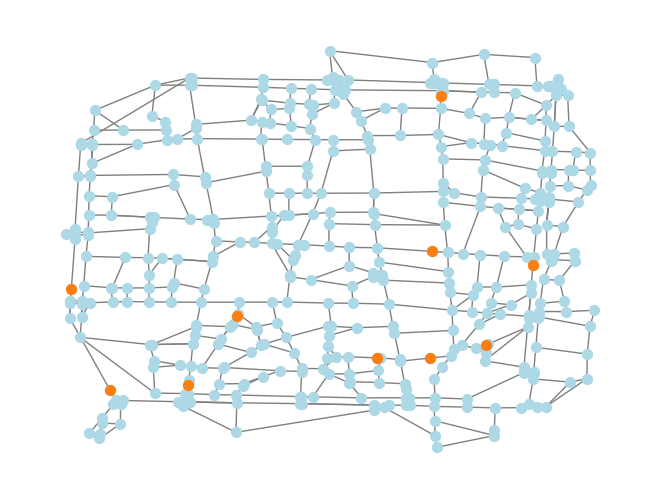

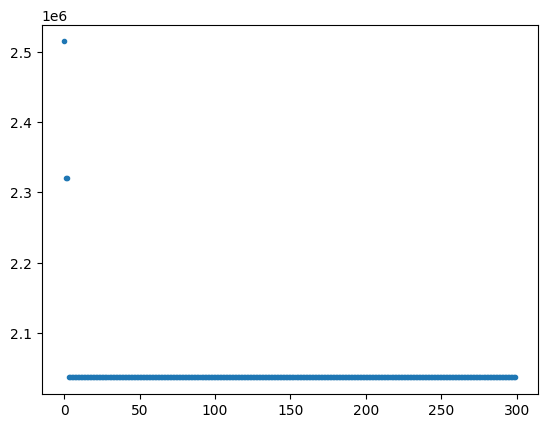

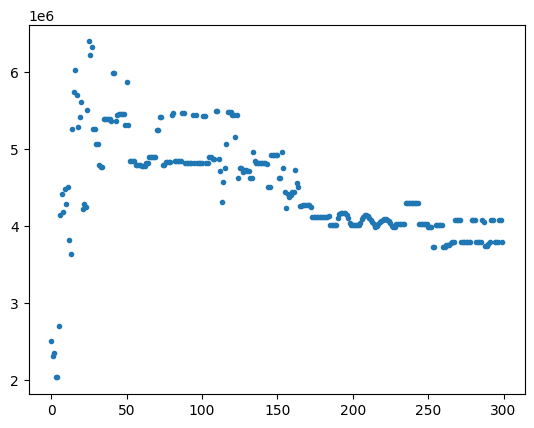

In [45]:
while m <= 10:
    print('Number of facilities: '+ str(m))
    start_xn = time.time()
    xn_set = []
    cost_xn = []
    iter_collect = []
    for n in random_test:
        x0 = sample_gen(n,m)
        xn,iter_data = gradient_momentum(x0)
        xn_set.append(xn)
        cost_xn.append(cost(xn))
        iter_collect.append(iter_data)
    stop_xn = time.time()    
    k = cost_xn.index(min(cost_xn))
    print('Function cost(x0) values is '+ str(cost_xn[k]))
    print('Time used in Gradient decent (momentum) calculation: '+ str(stop_xn-start_xn))

    G,facility_list = facility_projection(xn_set[k])
    start_flow = time.time()
    t = 100
    flow = flow_te(t, G, facility_list)
    print('Function flow(100) values is '+ str(flow))
    stop_flow = time.time()
    print('Time used in flow(t) calculation: '+ str(stop_flow-start_flow))

    G_pos = nx.get_node_attributes(G, 'pos')
    edge_labels = nx.get_edge_attributes(G, "weight")
    
    nx.draw(G, G_pos, node_color='lightblue', edge_color='gray', node_size=50, font_size=8)
    nx.draw_networkx_nodes(G, G_pos, nodelist = facility_list, node_size = 50, node_color="tab:orange")
    plt.savefig('figure/network-bd-gd-momentum-'+ str(m) +'.pdf')
    plt.show()

    iter_count = len(iter_collect[k])
    iter_t = np.arange(iter_count)
    iter_set = []
    iter_dum = math.inf
    for i in range(iter_count):
        if iter_collect[k][i] < iter_dum:
            iter_set.append(iter_collect[k][i])
            iter_dum = iter_collect[k][i]
        else:
            iter_set.append(iter_dum)
    
    iter_plot = np.array(iter_set)
    plt.plot(iter_t,iter_plot, '.')
    plt.savefig('figure/iteration-bd-gd-momentum-'+ str(m) +'.pdf')
    plt.show()

    iter_plot = []
    for i in range(len(iter_collect[k])):
        iter_plot.append(iter_collect[k][i])
    iter_t = np.arange(len(iter_plot))
    iter_plot = np.array(iter_plot)
    plt.plot(iter_t,iter_plot, '.')
    plt.show()

    data_result.append([m,flow,stop_flow-start_flow,cost_xn[k],stop_xn-start_xn])
    iter_df.append(iter_set)
    xn_df.append(xn_set[k])
    m+=1

In [46]:
iter_df = pd.DataFrame(iter_df)
iter_df = iter_df.transpose()
iter_df.to_csv('csv/iteration-bd-gd-momentum.csv', index=False)
iter_df

,0,1,2,3,4,5,6,7,8,9
0,1.859221e+07,9.575987e+06,5.131122e+06,4.622034e+06,4.402979e+06,4.020587e+06,3.569703e+06,2.629983e+06,2.576245e+06,2.514886e+06
1,1.790589e+07,7.487732e+06,4.444335e+06,3.682793e+06,3.289307e+06,2.910850e+06,2.707708e+06,2.474859e+06,2.469694e+06,2.320408e+06
2,1.790589e+07,7.487732e+06,4.444335e+06,3.682793e+06,3.289307e+06,2.910850e+06,2.707708e+06,2.382705e+06,2.390987e+06,2.320408e+06
3,1.790589e+07,7.487732e+06,4.444335e+06,3.682793e+06,3.289307e+06,2.910850e+06,2.707708e+06,2.048564e+06,2.012158e+06,2.036633e+06
4,1.790589e+07,7.487732e+06,4.444335e+06,3.682793e+06,3.289307e+06,2.910850e+06,2.707708e+06,2.010675e+06,1.998998e+06,2.036633e+06
...,...,...,...,...,...,...,...,...,...,...
295,1.790589e+07,7.487732e+06,4.444335e+06,3.682793e+06,3.289307e+06,2.910850e+06,2.707708e+06,2.010675e+06,1.998998e+06,2.036633e+06
296,1.790589e+07,7.487732e+06,4.444335e+06,3.682793e+06,3.289307e+06,2.910850e+06,2.707708e+06,2.010675e+06,1.998998e+06,2.036633e+06
297,1.790589e+07,7.487732e+06,4.444335e+06,3.682793e+06,3.289307e+06,2.910850e+06,2.707708e+06,2.010675e+06,1.998998e+06,2.036633e+06
298,1.790589e+07,7.487732e+06,4.444335e+06,3.682793e+06,3.289307e+06,2.910850e+06,2.707708e+06,2.010675e+06,1.998998e+06,2.036633e+06


In [47]:
xn_df = pd.DataFrame(xn_df)
xn_df = xn_df.transpose()
xn_df.to_csv('csv/xn-bd-gd-momentum.csv', index=False)
xn_df

,0,1,2,3,4,5,6,7,8,9
0,98.985036,98.990832,98.992678,98.993333,98.993346,98.993346,98.993346,98.992825,98.992835,98.993347
1,18.783304,18.788138,18.786429,18.788413,18.788416,18.788416,18.788416,18.786947,18.786968,18.787431
2,NaN,98.974979,98.981788,98.982170,98.982287,98.983689,98.983721,98.982444,98.982302,98.983012
3,NaN,18.782007,18.782973,18.783369,18.783486,18.784887,18.784920,18.785599,18.785467,18.785210
4,NaN,NaN,98.980791,98.980879,98.982611,98.982812,98.982812,98.972468,98.972269,98.976860
5,NaN,NaN,18.789028,18.789097,18.789341,18.789491,18.789491,18.784398,18.784231,18.786397
6,NaN,NaN,NaN,98.991449,98.991785,98.991785,98.991830,98.991162,98.991344,98.991557
7,NaN,NaN,NaN,18.784128,18.784464,18.784464,18.784508,18.783900,18.784082,18.783829
8,NaN,NaN,NaN,NaN,98.990538,98.990557,98.990615,98.988832,98.988936,98.989751
9,NaN,NaN,NaN,NaN,18.787673,18.787692,18.787750,18.788043,18.788151,18.787930


In [48]:
df = pd.DataFrame(data_result, columns=['facility number','flow(t)','flow time','cost(x)','cost time'])
df.to_csv('csv/result-bd-gd-momentum.csv', index=False)
df

,facility number,flow(t),flow time,cost(x),cost time
0,1,320,844.841350,1.790589e+07,760.676904
1,2,489,836.399498,7.487732e+06,1110.373138
2,3,1053,921.985879,4.444335e+06,1546.769509
3,4,1429,844.378615,3.682793e+06,2011.946403
4,5,2057,853.765329,3.289307e+06,2384.604903
5,6,2131,816.873281,2.910850e+06,2731.423959
6,7,2420,829.903779,2.707708e+06,3139.372842
7,8,3067,834.022114,2.010675e+06,3621.049656
8,9,3449,841.813784,1.998998e+06,4087.651032
9,10,3460,843.165504,2.036633e+06,4552.257479
